# Question 4

In [2]:
# import pystan
import numpy as np
import matplotlib.pyplot as plt
import random

In [0]:
#(a)

#load poisson data
data = np.loadtxt('q3_poisson.txt')
x, y = data
y_int = [int(i) for i in y]

In [0]:
#Stan program implementing the Poisson regression model
code = """
data {
  int N;
  vector[N] x;
  int y[N];
}
parameters {
  real alpha;
  real beta;
}
model {
  alpha ~ normal(0,10);
  beta ~ normal(0,10);
  for (n in 1:N){
    y[n] ~ poisson(exp(alpha * x[n] + beta));
  }
}
"""
sm = pystan.StanModel(model_code=code)

In [0]:
#extract the results (alpha, beta)
result = sm.sampling(data={"N": len(x), "x": x, "y": y_int}, iter=10000, chains=1)
alpha_samples = result.extract()["alpha"]
beta_samples = result.extract()["beta"]

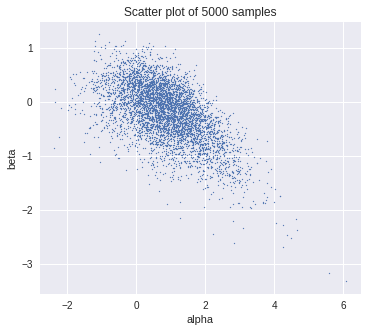

In [24]:
#scatter plot
fig = plt.gcf()
fig.set_size_inches(5.75,5)
plt.scatter(alpha_samples,beta_samples,s=1)

plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Scatter plot of 5000 samples')
plt.legend()
plt.show()

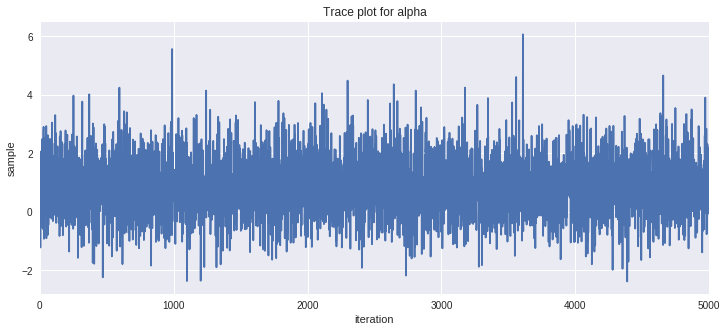

In [57]:
#2 trace plots
plt.xlim(0,5000)
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('iteration')
plt.ylabel('sample')
plt.title('Trace plot for alpha')
plt.legend()

t_1 = [t for t in np.arange(0,5000,1)] 
plt.plot(t_1, alpha_samples)

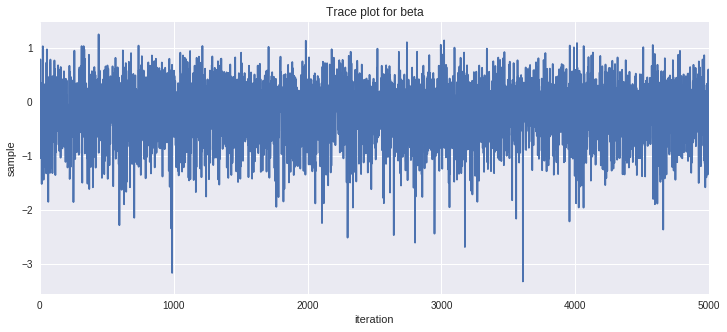

In [58]:
plt.xlim(0,5000)
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.xlabel('iteration')
plt.ylabel('sample')
plt.title('Trace plot for beta')
plt.legend()

plt.plot(t_1, beta_samples)

In [30]:
#mean
alpha_posterior_mean = np.average(alpha_samples)
beta_posterior_mean = np.average(beta_samples)
print('Alpha posterior mean:%s'%alpha_posterior_mean)
print('Beta posterior mean:%s'%beta_posterior_mean)

#correlation coefficient
corrcoef = np.corrcoef(alpha_samples, beta_samples)
print('Correlation coefficient:%s'%corrcoef)

Alpha posterior mean:0.8507627701867139
Beta posterior mean:-0.1967548746423803
Correlation coefficient:[[ 1.         -0.59120525]
 [-0.59120525  1.        ]]


Conclusion:

The chains of alpha and beta are well "mixed" because it is hard to "see" any structure in them and predicting values of future samples from the current one is difficult.

Yes, we get the similar results as in Question 3 (c).

In [10]:
#(b)

#load the file 'pca.stan'
sm_pca = pystan.StanModel(file='pca.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f8e00c34386396f63d525d9187e4610 NOW.


In [11]:
#model of pca.stan
print(sm_pca)

StanModel object 'anon_model_4f8e00c34386396f63d525d9187e4610' coded as follows:

data {
        int<lower=0> N; // Number of samples
	int<lower=0> D; // The original dimension
	int<lower=0> K; // The latent dimension
	matrix[N, D] X; // The data matrix
	real mu_W;      // Mean of prior of W
	real alpha0;    // hyperparam for gamma distr of alpha
	real beta0;     // hyperparam for gamma distr of alpha
}

parameters {
	matrix[N, K] Z; // The latent matrix
	matrix[D, K] W; // The weight matrix
	real<lower=0> tau; // Precision of X (noise term) 
	vector<lower=0>[K] alpha; // Precision of W
}

transformed parameters{
	vector<lower=0>[K] t_alpha;
	real<lower=0> t_tau;
	t_alpha = 1 ./ sqrt(alpha);
	t_tau = 1 ./ sqrt(tau);
}

model {
      tau ~ gamma(1, 1);
      alpha ~ gamma(alpha0, beta0);				
      for(k in 1:K) {
        W[,k] ~ normal(mu_W, t_alpha[k]);
      }	
      for(n in 1:N){
      	Z[n] ~ normal(0, 1);
	X[n] ~ normal(W * Z[n]', t_tau);
      }
} 




In [18]:
#(c)

#load data 'q4_pca.txt'
X = np.loadtxt('q4_pca.txt')

In [0]:
#generate 10000 posterior samples 
data = {"N": 15, "D": 3, "K": 2, "X": X.T, "mu_W": 0, "alpha0": 1, "beta0": 1}
result_pca = sm_pca.sampling(data=data, iter=10000, chains=2, n_jobs=2)

In [0]:
#extract the results (W,tau)
W_sample = result_pca.extract()["W"]
tau_sample = result_pca.extract()["tau"]

In [0]:
#pick randomly 25 of 10000 samples
W_random = np.zeros((25,3,2))
tau_random = np.zeros((25,))

#compute convariance matrix
C_random = np.zeros((25,3,3))
for i in range(25):
  n = random.randint(1,10000)
  W_random[i] += W_sample[n]
  tau_random[i] += tau_sample[n]
  C_random[i] += np.dot(W_sample[n], W_sample[n].T) + (1/tau_sample[n]) * np.identity(3)

In [0]:
#Bayesian PCA
v_matrix = np.zeros((25,2,3))
u_matrix = np.zeros((25,2,3))
for i in range(25):
  e_values, e_vectors = np.linalg.eig(C_random[i])
  e_values_dict = {}
  
  for a, b in enumerate(e_values):
    e_values_dict[b] = a
  e_values.sort()
  
  value_1 = e_values[2]
  value_2 = e_values[1]
  
  index_1 = e_values_dict[value_1]
  index_2 = e_values_dict[value_2]
  
  v_1 = e_vectors[:,index_1]
  v_2 = e_vectors[:,index_2]
  v_matrix[i][0] += v_1
  v_matrix[i][1] += v_2
  
  u_1 = v_1 * np.sqrt(value_1)
  u_2 = v_2 * np.sqrt(value_2)
  u_matrix[i][0] += u_1
  u_matrix[i][1] += u_2

In [0]:
#Standard PCA
v_matrix_stan = np.zeros((2,3))
u_matrix_stan = np.zeros((2,3))

cov = np.cov(X)
e_values, e_vectors = np.linalg.eig(cov)
e_values_dict = {}

for a, b in enumerate(e_values):
  e_values_dict[b] = a
e_values.sort()

value_1 = e_values[2]
value_2 = e_values[1]

index_1 = e_values_dict[value_1]
index_2 = e_values_dict[value_2]

v_1 = e_vectors[:,index_1]
v_2 = e_vectors[:,index_2]
v_matrix_stan[0] += v_1
v_matrix_stan[1] += v_2

u_1 = v_1 * np.sqrt(value_1)
u_2 = v_2 * np.sqrt(value_2)
u_matrix_stan[0] += u_1
u_matrix_stan[1] += u_2

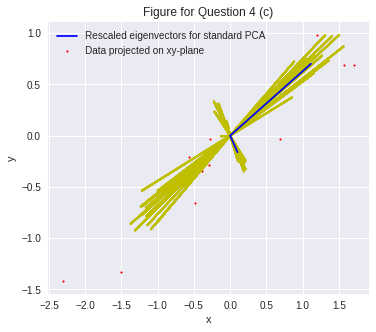

In [77]:
#Projections

#Bayesian PCA
projected_data = np.zeros((15,2))
u_projected_1 = np.zeros((25,2))
u_projected_2 = np.zeros((25,2))

#project data on xy-plane
for n in range(15):
  projected_data[n] = X[:2,n]
  if n is not 14:
    plt.scatter(projected_data[n][0], projected_data[n][1], s=3, color='r')
  else:
    plt.scatter(projected_data[n][0], projected_data[n][1], s=3, color='r',label='Data projected on xy-plane')

#project rescaled eigenvectors on xy-plane
for i in range(25):
  for n in range(15):   
    u_projected_1[i] = u_matrix[i][0][:2]
    u_projected_2[i] = u_matrix[i][1][:2]
    plt.plot([0, u_projected_1[i][0]], [0, u_projected_1[i][1]], color='y')
    plt.plot([0, u_projected_2[i][0]], [0, u_projected_2[i][1]], color='y')


    
#Standard PCA 

#project rescaled eigenvectors on xy-plane
u_projected_stan_1 = u_matrix_stan[0][:2]
u_projected_stan_2 = u_matrix_stan[1][:2]
plt.plot([0, u_projected_stan_1[0]], [0, u_projected_stan_1[1]], color='b',label='Rescaled eigenvectors for standard PCA')
plt.plot([0, u_projected_stan_2[0]], [0, u_projected_stan_2[1]], color='b')
  
fig = plt.gcf()
fig.set_size_inches(5.75,5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figure for Question 4 (c)')
plt.legend()
plt.show()

Brief comparison:

From the figure above, the distribution of u1, u2 looks like similar with the vectors obtained by standard PCA. For the vectors with similar directions in two versions of PCA, the length (eigenvalue) and direction of the vector from standard PCA is more likely to be the average or the expectation of length (eigenvalue) and directions of all the sampled vectors from Bayesian PCA. 

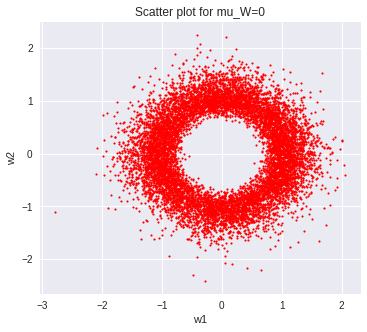

In [68]:
#(d)

#Scatter plot for mu_W=0
for i in range(10000):
  plt.scatter(W_sample[i][0][0], W_sample[i][0][1], s=3, color='r')
fig = plt.gcf()
fig.set_size_inches(5.75,5)
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Scatter plot for mu_W=0')
plt.legend()
plt.show()

Explanation:

From the figure above, the scatter plot looks like a circle, and the majority of sampled points approximately satisfies the relationship: w21 + w22 =1. 
First, from Question 4(c) we know that the distribution of rescaled eigenvectors from Bayesian PCA should be similar with the one from regular PCA. Then the covariance matrix of Bayesian PCA should be also similar with the empirical covariance matrix of regular PCA since the rescaled eigenvectors are obtained by the eigen-decomposition of the covariance matrix. Hence, from the equation (16) in the assignment, mean of the upper-left corner element of covariance matrix C, which is w21 + w22+1/τ, should be similar with the upper-left corner element of empirical covariance matrix of X (X is the dataset, a 3x15 matrix). From the calculation, we know the upper-left corner element of empirical covariance matrix,is 1.2582 and the average of all 10000 sampled τ is 10.2457. Therefore, the average of w21 + w22 should be close to 1.2582-1/10.2457=1.1606, which shows why the scatter plot should be like a circle above. (Here we have not centered the data in preprossing)

In [0]:
#change mu_W = 1 and re-sample
data_1 = {"N": 15, "D": 3, "K": 2, "X": X.T, "mu_W": 1, "alpha0": 1, "beta0": 1}
result_pca_1 = sm_pca.sampling(data=data_1, iter=10000, chains=2, n_jobs=2)

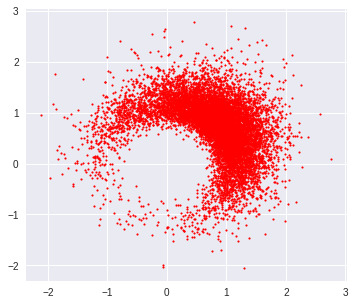

In [23]:
#Scatter plot for mu_W=1
W_sample_1 = result_pca_1.extract()["W"]

for i in range(10000):
  plt.scatter(W_sample_1[i][0][0], W_sample_1[i][0][1], s=3, color='r')
fig = plt.gcf()
fig.set_size_inches(5.75,5)
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Scatter plot for mu_W=1')
plt.legend()
plt.show()

Explanation:

From the figure above, there are more sampled points concentrating at around (1,1), whereas less sampled points locating in the other half of the circle (w21)2 + (w22)2 =1. We can understand the difference between two plots as a process that the sampled points in the plot with mu_W=1 gradually tries to be close to the true distribution in the plot with mu_W=0, which starts from a Gaussian prior with mean (1,1). In the beginning of sampling, the most sampled points concentrate at around (1,1) because of the effect of Gaussian prior. Then after observing the true data, the following sampled points start to move to the region of space where the true distribution of (w1,w2) is. In other word, the following sampled points try to form a shape of the circle, which is the true distribution of (w1,w2) as the plot with mu_W=0. To verify our explanation, we also make a scatter plot with iter=30000. The figure below clearly shows that there are relative more sampled points locating in the other half of the circle, and the whole shape of scatter plot tries and tends to form the circle as we obtained before.

In [0]:
#As comparison, we also make a plot with mu_W=1 and iter=30000

#change iter=30000
data_2 = {"N": 15, "D": 3, "K": 2, "X": X.T, "mu_W": 1, "alpha0": 1, "beta0": 1}
result_pca_2 = sm_pca.sampling(data=data_2, iter=30000, chains=2, n_jobs=2)

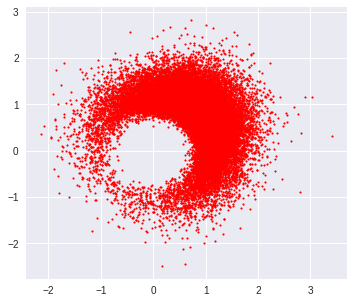

In [56]:
W_sample_2 = result_pca_2.extract()["W"]

for i in range(30000):
  plt.scatter(W_sample_2[i][0][0], W_sample_2[i][0][1], s=3, color='r')
fig = plt.gcf()
fig.set_size_inches(5.75,5)
plt.show()

In [50]:
#We compute the covariance matrix of X

#Covariance matrix of X
np.cov(X)

array([[ 1.25822803,  0.76660901, -0.01466818],
       [ 0.76660901,  0.51875107, -0.01558232],
       [-0.01466818, -0.01558232,  0.01542962]])